# Scaling benchmarks
> Performance of the solver should improve with more data

In [2]:
import sys
sys.path.append('/Users/phil/Columbia/aPTR')
%load_ext autoreload
%autoreload 2

In [9]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

from src.database import RnaDB
from src.torch_solver import TorchSolver
from src.simulation import simulate_from_ids


# Scaling test 1:

Here we run OOM readcounts (metagenomic WGS simulation) and determine what errors
we get. Here's how the simulation runs:
* Select 10 genomes to use
* For each scaling factor:
    * Draw PTRs and abundances (TODO: keep these fixed)
    * Draw reads
    * Winnow reads to 16S regions
    * For each sample:
        * Solve using Torch solver
        * Evaluate RMSE of PTR and abundance estimates

Things to try in the future:
* Keep PTRs and abundances consistent
* Determine relationship between abundances/PTRs and accuracy
* More simulations per scaling factor ---> boxplots
* Visualize flow of reads genome ---> gene ---> seq via Sankey diagram

In [29]:
# Factored-out hyperparameters for scale test 1

N_GENOMES = 10
N_SAMPLES = 5
MIN_SCALE = 2
MAX_SCALE = 8
SOLVER_KWARGS = {
    "verbose": False,
}

In [46]:
# Initialize DB, grab 10 complete genomes
db = RnaDB()
genomes = db.db[db.db["n_contigs"] == 1]["genome"].unique()
genomes_to_use = np.random.choice(genomes, N_GENOMES, replace=False)
solver_genomes, _ = db.generate_genome_objects(genomes_to_use)

# Get some benchmarks going
scaling_results = pd.DataFrame(
    columns=[
        "scale",
        "sample",
        "genome",
        "abundance",
        "ptr",
        "loss",
        "true abundance",
        "true ptr",
    ]
)

for scale_exp in range(MIN_SCALE, MAX_SCALE):
    scale = 10 ** scale_exp
    print(f"Scale: {scale}")
    # Generate otus
    (
        reads_scaled,
        ptrs_scaled,
        coverages_scaled,
        otus_scaled,
    ) = simulate_from_ids(
        db=db.db,
        ids=genomes_to_use,
        fasta_path="/home/phil/aptr/data/seqs",
        n_samples=N_SAMPLES,
        scale=scale,
        shuffle=False,  # Suppress shuffling to conserve memory
        fastq=False,
        verbose=False,
    )

    for sample in otus_scaled:
        solver = TorchSolver(genomes=solver_genomes, coverages=sample)
        a_hat, b_hat = solver.solve(**SOLVER_KWARGS)

        for genome, a, b, true_abundance, true_ptr in zip(
            solver_genomes,
            a_hat,
            b_hat,
            coverages_scaled[sample],
            ptrs_scaled[sample],
        ):
            scaling_results = scaling_results.append(
                {
                    "scale": scale,
                    "sample": sample,
                    "genome": genome["id"],
                    "abundance": torch.exp(a).item(),
                    "ptr": 1 + b.item(),
                    "loss": solver.best_loss.item(),
                    "true abundance": true_abundance,
                    "true ptr": true_ptr,  # Assume same indexing
                },
                ignore_index=True,
            )
    print()


/Users/phil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Scale: 100


/Users/phil/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([39])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Scale: 1000

Scale: 10000

Scale: 100000

Scale: 1000000

Scale: 10000000



In [31]:
# Compute errors
# TODO: put this into the main loop

scaling_results["ptr error"] = np.clip(
    np.abs(scaling_results["ptr"] - scaling_results["true ptr"]),
    0,
    1e3
)

scaling_results["abundance error"] = np.clip(
    np.abs(scaling_results["abundance"] - scaling_results["true abundance"]),
    0,
    1e3
)

<AxesSubplot:title={'center':'ptr error'}, xlabel='scale'>

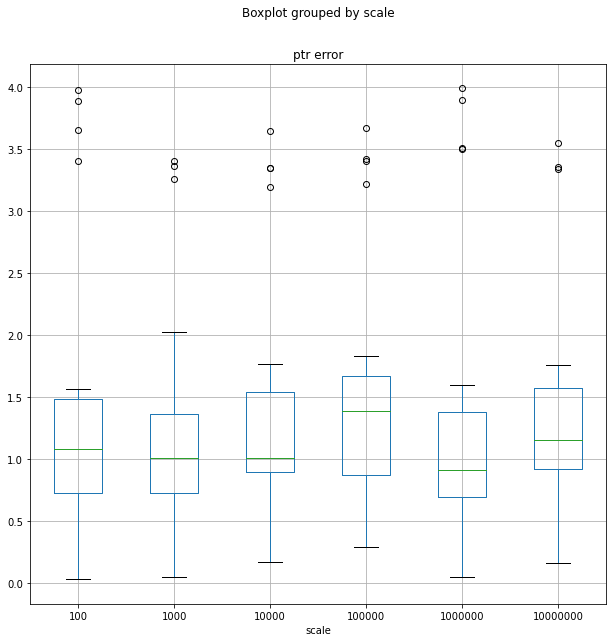

In [36]:
scaling_results.boxplot("ptr error", by="scale", figsize=(10,10))

In [43]:
scaling_results["baseline error"] = np.abs(1.5 - scaling_results["true ptr"])

In [37]:
scaling_results

,scale,sample,genome,abundance,ptr,loss,true abundance,true ptr,ptr error,abundance error
0,100,0,862969.3,0.019663,2.635353,0.011511,30,1.156627,1.478726,29.980337
1,100,0,224013.5,0.026496,2.740151,0.011511,135,1.533056,1.207096,134.973504
2,100,0,1286.18,0.019519,2.747348,0.011511,0,1.685763,1.061585,0.019519
3,100,0,865938.3,0.031705,2.583710,0.011511,32,1.180401,1.403309,31.968295
4,100,0,272558.8,0.029656,2.608176,0.011511,12,1.409302,1.198873,11.970344
...,...,...,...,...,...,...,...,...,...,...
145,10000000,4,862969.3,0.716471,2.683352,0.740969,6336670,1.103554,1.579798,1000.0
146,10000000,4,224013.5,0.606614,-2.092442,0.740969,5550577,1.450757,3.543199,1000.0
147,10000000,4,1286.18,1.471518,1.000000,0.740969,19672620,1.922331,0.922331,1000.0
148,10000000,4,865938.3,1.708747,2.775284,0.740969,758274,1.200963,1.574320,1000.0


In [35]:
scaling_results.to_pickle("~/aPTR/data/scaling_1_out.pkl")

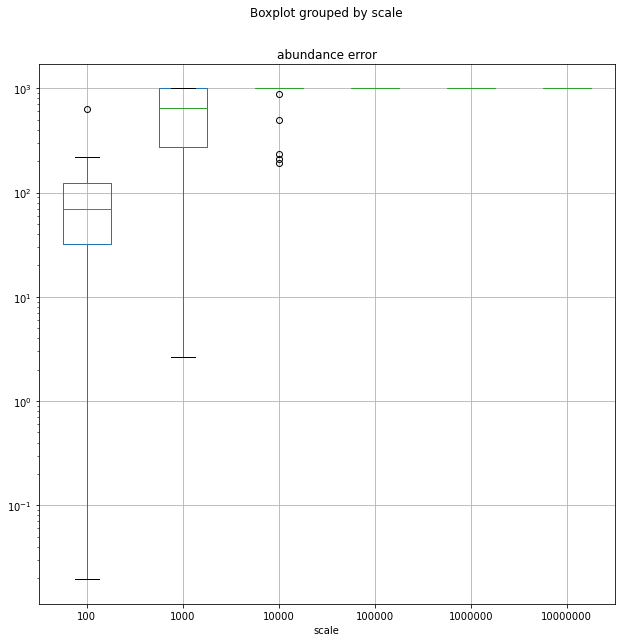

In [40]:
scaling_results.boxplot("abundance error", by="scale", figsize=(10,10))
plt.yscale("log")

array([<AxesSubplot:title={'center':'ptr error'}, xlabel='scale'>,
       <AxesSubplot:title={'center':'baseline error'}, xlabel='scale'>],
      dtype=object)

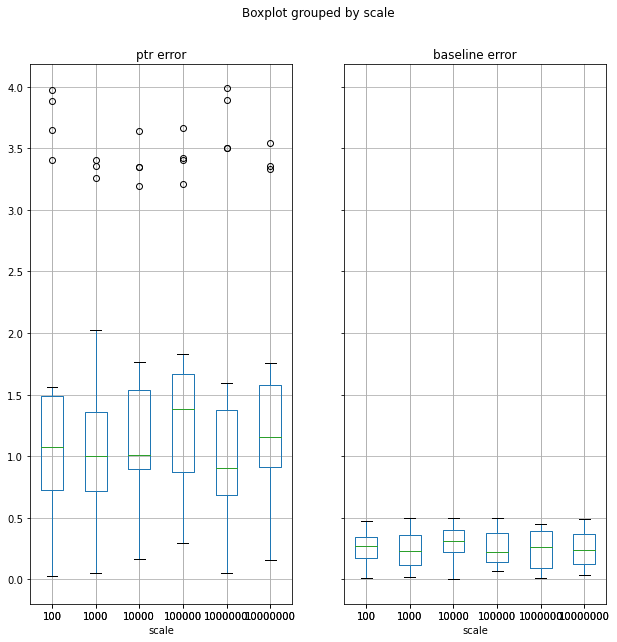

In [45]:
scaling_results.boxplot(["ptr error", "baseline error"], by="scale", figsize=(10,10))